# `Практикум по программированию на языке Python`
<br>

## `Занятие 11: Методы повышения эффективности кода`
<br><br>

### `Роман Ищенко (roman.ischenko@gmail.com)`

#### `Москва, 2024`

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### `Производительность Python`

- Быстродействие кода на Python существенно уступает коду, написанному на компилируемых языках<br><br>
- Но Python очень удобен и популярен, поэтому сделано много попыток его ускорения<br><br>
- Популярен подход с написанием основного кода на C/C++/CUDA и предоставлением пользователю удобного интерфейса к нему в Python (numpy, pycuda, библиотеки для глубинного обучения)<br><br>
- Однако часто хочется получать эффективный код прямо в Python

### `Возможные методы повышения производительности`

- Многопоточность и многопроцессорность
- Альтернативные реализации Python: Pypy, Jython, Iron Python
- Библиотека Numba
- Расширение Cython
- Фреймворки Hadoop/Spark

### `Процесс и поток`

- __Процесс__ - это единица приложения, работающая в операционной системе, имеет собственную изолированную память
- __Поток__ - вычислительная единица внутри процесса, работает в памяти процесса, имеет собственный код для выполнения<br><br>
- В процессе может быть >= 1 потока
- Одно ядро процессора в моменте времени может выполнять код одного потока
- Если потоков много, а ядро одно, то оно будет переключаться между ними, создавая иллюзию параллельности для пользователя
- Если и потоков, и ядер много, то потоки могут действительно выполняться параллельно
- Аналогичным образом работает параллелизм между процессами

### `Создание потока в Python`

- Для работы с потоками в Python есть стандартный модуль threading
- Основным классом является `Thread` (поток)

In [ ]:
import threading

Функциональное создание потока:

In [ ]:
def thread_function(x):
    print(x ** 3)

thread = threading.Thread(target=thread_function, args=(10, ))
thread.start()

# thread.start()  # RuntimeError: threads can only be started once

- Потоку передается функция, которую он должен выполнить, и аргументы
- После запуска `start` он будет выполняться до выхода из функции или ошибки
- Запустить его второй раз не получится (RuntimeError)

### `Создание потока в Python`

- Поток также можно описать в виде класс-наследника `Thread`
- Класс должен определять метод `run`

In [ ]:
class MyThread(threading.Thread):
    def __init__(self, x, power):
        threading.Thread.__init__(self)
        self.x = x
        self.power = power

    def thread_function(self):
        print(self.x ** self.power)

    def run(self):
        self.thread_function()

print_thread = MyThread(x=10, power=3)
print_thread.start()

# print_thread.start()  # RuntimeError: threads can only be started once

### `Потоки-демоны`

- Потоки могут выполняться в обычном и фоновом (daemon) режимах
- Потоки-демоны используются для выполнения фоновых задач (отправка ping-ов, очистка мусора), они имеют смысл только в процессе существования основного потока
- При своем завершении процесс будет дожидаться окончания работы обычных потоков
- Потоки-демоны будут автоматически уничтожены при завершении процесса
- Такие потоки можно создавать и дальше за ними не следить, обычные же потоки нужно явно завершать<br><br>

Создание потока в режиме демона:

In [ ]:
from threading import Thread
import time


def show_timer():
    count = 0
    while True:
        count += 1
        time.sleep(1)
        print(f'Ждём {count} секунд...', end='\r')


# t = Thread(target=show_timer)
t = Thread(target=show_timer, daemon=True)
t.start()

answer = input('Press any key for exit\n')
print('Done')

### `Основные методы и атрибуты класса Thread`

Методы:

- `start` - запуск потока
- `run` - выполняет код потока
- `join` - блокирует вызывающий поток до завершения потока, у которого вызван `join`
- `is_alive` - возвращает флаг незавершенности потока

Атрибуты:
- `name` - имя потока
- `daemon` - флаг потоком фоновый или обычный
- `ident` - идентификатор потока, пока не вызван `start` он `None`.

### `Пример запуска потока`

In [ ]:
import time

def wait(s):
    print('wait started')
    time.sleep(s)
    print('wait finished')

thread = threading.Thread(target=wait, args=(10, ), name='Wait Thread')
thread.start()

print('Is alive: ', thread.is_alive())
print('Is daemon: ', thread.daemon)
print('Thread name: ', thread.name)
print('Thread identificator: ', thread.ident)
thread.join()
print('Is alive: ', thread.is_alive())

### `Доступ к разделяемым ресурсам`

- Потоки не имеют своей памяти и все работают с одной памятью родительского процесса
- Порядок выполнения потоков недетерминирован, в многопоточной среде несколько потоков могут одновременно получить доступ к одному ресурсу
- Без надлежащего контроля это может привести к ошибкам и падению процесса
- Потоки нельзя просто так останавливать извне, поэтому ограничения нужно наложить заранее, до запуска<br><br>

- Для контроля за доступом к ресурсам есть несколько инструментов:
    - Мьютекс (Mutex, Lock)
    - Рекурсивный мьютекс (RLock)
    - Семафор (Semaphore)
    - Событие (Event)
    - Условная переменная (Condition variable)
    - Барьер (Barrier)

### `Простая блокировка Lock`

- Mutex - это объект, который может в каждый момент времени быть занят не более чем одним потоком
- Все потоки проверяют его на занятость и, если он занят, ожидают освобождения

In [ ]:
mutex = threading.Lock()

def thread_safe_function():
    mutex.acquire()
    # Critical section
    mutex.release()

Для избежания взаимных блокировок (deadlocks) освобождение mutex нужно делать всегда, в т.ч. при ошибках и исключениях

### `Пример использования Mutex`

Сравним потокобезопасный и непотокобезопасный коды в задаче инкремента разделяемого ресурса ([источник](https://geekbrains.ru/posts/python_multithreading_pt2))

In [ ]:
protected_resource, unprotected_resource = 0, 0
mutex = threading.Lock()
NUM = 100000

In [ ]:
def safe_plus():
    global protected_resource
    for i in range(NUM):
        with mutex:
            protected_resource += 1

def risky_plus():
    global unprotected_resource
    for i in range(NUM):
        unprotected_resource += 1

def safe_minus():
    global protected_resource
    for i in range(NUM):
        with mutex:
            protected_resource -= 1

def risky_minus():
    global unprotected_resource
    for i in range(NUM):
        unprotected_resource -= 1

### `Пример использования Mutex`

- Race condition приводит к случайному результату: из-за неатомарности обновления часть операций теряется

In [ ]:
thread1 = threading.Thread(target=safe_plus)
thread2 = threading.Thread(target=safe_minus)
thread3 = threading.Thread(target=risky_plus)
thread4 = threading.Thread(target=risky_minus)

thread1.start(), thread2.start(), thread3.start(), thread4.start()
thread1.join(), thread2.join(), thread3.join(), thread4.join()

print (f'Threadsafe result: {protected_resource}')
print (f'Non-threadsafe result: {unprotected_resource}')

### `Прочие инструменты контроля доступа`

- Рекурсивный мьютекс - такой же, как и обычный, но один поток может многократно входить в критическую секцию<br><br>
- Семафор - дает доступ к ресурсу заданному числу потоков<br><br>
- Событие - блокирует ресурс до выполнения некоторого условия, о котором уведовляет один из потоков<br><br>
- Условная переменная - обертка типа Event вокруг других блокировок для блокирования по определенным событиям<br><br>
- Барьер - создает точку синхронизации для заданного числа потоков, пока они все не дойдут до него, никто дальше не выполняется

In [ ]:
s = threading.Semaphore(4)

s.acquire()
s.release()


e = threading.Event()

e.wait()
e.is_set()
e.set()
e.clear()

### `Проблемы с многопоточностью в Python`

- Существует несколько реализаций Python, наиболее популярная (стандартная) - CPython
- Исторически CPython был реализован с глобальной блокировкой потоков Global Interpreter Lock (GIL)

Что такое GIL:
- GIL - это блокировка, которая не позволяет в каждый момент времени выполняться не более чем одному потоку
- Для этого через равные промежутки времени (100 тиков) интерпретатор усыпляет работающий поток и дает возможность поработать один промежуток какому-то иному потоку
- Остановка происходит даже в том случае, если поток всего один
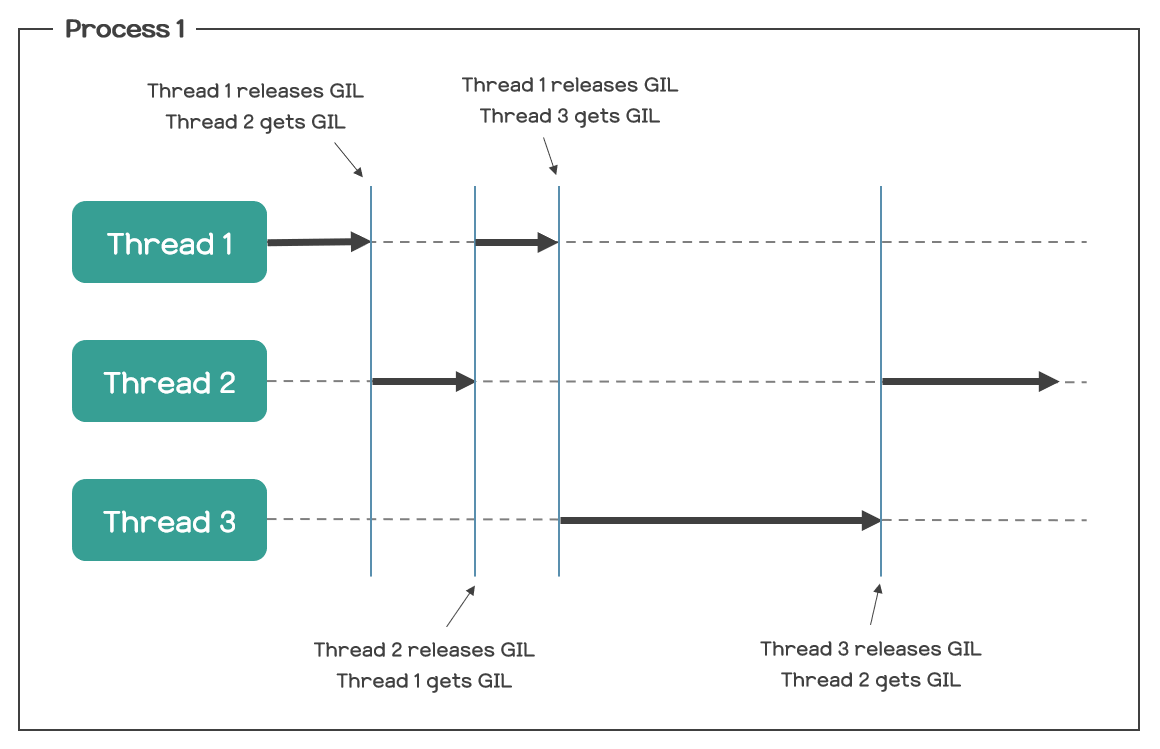


Зачем нужен GIL:
- Реализация менеджмента памяти и сборки мусора в CPython не является потокобезопасной
- Без него C-расширения языка, которые активно используются, не смогут нормально работать
- За счет отсутствия необходимости учета разных ссылок на объекты из разных потоков однопоточные приложения выполняются с GIL быстрее

Где еще есть GIL:
- В Jython и IronPython GIL нет
- В PyPy есть
- В Cython есть, но может выключаться на секцию кода

### `К чему приводит наличие GIL`

- Многопоточные приложения, ориентированные на использование вычислений на CPU (не I/O операций) не могут работать параллельно<br><br>
- Вычисления не только не становятся быстрее, но и сильно замедляются при увеличении числа потоков, поскольку каждое переключение требует большого числа системных вызовов<br><br>
- Замедление на многоядерном процессоре будет еще больше, чем на одноядерном, поскольку интерпретатор не синхронизирован с ОС (он хочет разместить все на одном ядре, а ОС пытается разложить потоки на разные ядра)<br><br>
- В интерпретаторе нет своего расписания очереди потоков, используется расписание ОС, это приводит к проблемам при обработке сигналов

### `Реакция на сигналы ОС`

- В Python сигналы могут обрабатываться только в главном потоке<br><br>
- При этом интерпретатор не может сам потребовать, чтобы на следующем промежутке включился главный поток<br><br>
- Он пытается переключать потоки с GIL не раз в 100 тиков, а каждый тик<br><br>
- В результате выполнение кода может замедлиться, и до перехода в главный поток Python не реагирует на сигналы<br><br>
- Помимо этого, внутри одного тика интерпретатор невозможно прервать<br><br>
- Тик длится не фиксированное время, а некоторый набор инструкций (по-умолчанию - 100 байткодов), в которые интерпретатор транслировал исходный код<br><br>

### `Пример проблем с GIL`

Однопоточный код:

In [ ]:
def func(i):
    while i < 5e+7: i += 1

ts = time.time()
func(0)
print(f'Elapsed time: {round(time.time() - ts, 2)}')

Многопоточный код:

In [ ]:
ts = time.time()
threads = []
for _ in range(2):
    thread = threading.Thread(target=func, args=(0, ))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

print(f'Elapsed time: {round(time.time() - ts, 2)}')

### `Когда многопоточный код полезен`

- Независимые и не интенсивные I/O-операции с файлами, запросами или БД, логгирование<br><br>
    - время ожидание завершения работы системных вызовов, связанных с I/O-операциями относительно велико
    - поток, ожидающий этого, не меняет ничего в состоянии интерпретатора до выполнения следующего фрагмента кода
    - значит на это время он может освободить GIL и дать другому потоку продолжить выполнение<br><br>

- Отрисовка GUI

Пример с логгированием:

In [ ]:
flag = True
def print_message():
    while flag:
        time.sleep(1)
        print('I print this while func works')
    
log_thread = threading.Thread(target=print_message)
log_thread.start()
func(-5e+7)
print('Finished')
flag = False

### `Будущее GIL`

- Проблема с GIL действительно есть, однако её важность для большинства пользователей преувеличена
- Попытки избавиться от GIL предпринимались многократно, но часто проваливались из-за требования неухудшения производительности для однопоточных приложений
- Но есть и успешные перспективные примеры (https://github.com/colesbury/nogil)
- Одна из возможных альтернатив - механизм подинтерпретаторов (subinterpreters, версия Python 3.9+)
- Пробуются разные идеи, основанные на изменении методов подсчёта ссылок, аллокации памяти и принципов работы виртуальной машины

### `Многопроцессорный параллелизм`

- Процессы работают в собственных адресных пространствах и имеют каждый свои данные, в т.ч. и GIL в случае Python
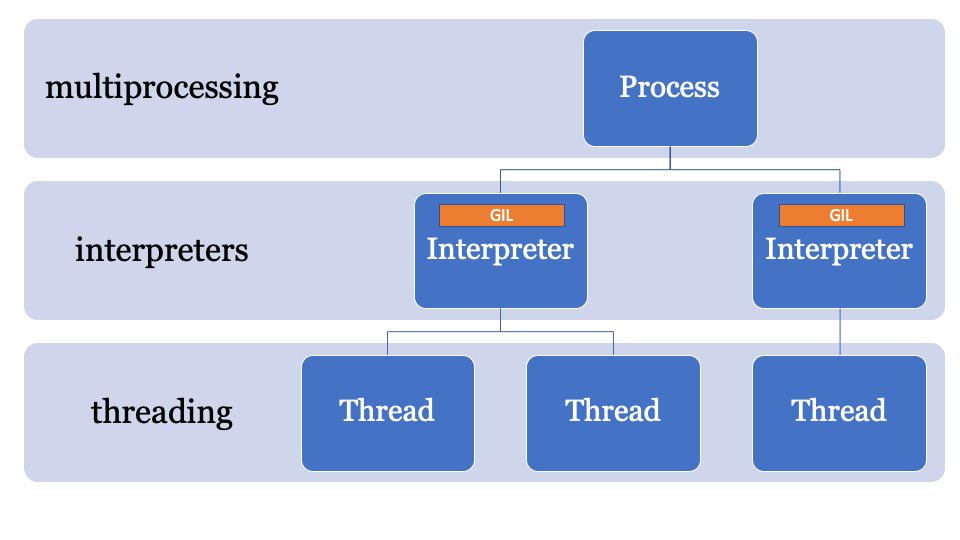

- Взаимодействие между ними можно организовать также, как и для любых других процессов: через файлы (в т.ч. вирутуальные) или обмен сообщениями (multiprocessing, MPI)<br><br>

- У каждого процесса есть `pid`, который можно получить вызовом `os.getpid()`
- Воспользуемся для примера модулем multiprocessing, все похоже на потоки:

In [ ]:
import os
from multiprocessing import Process

def func(number):
    result = number ** 2
    print(f'func was called by process id {os.getpid()} with number {number}')

procs, numbers = [], [5, 10, 15, 20, 25]
    
for index, number in enumerate(numbers):
    proc = Process(target=func, args=(number,))
    procs.append(proc)
    proc.start()
    
for proc in procs:
    proc.join()

### `Блокировки для процессов`

- `multiprocessing.Lock` реализован как объект семафора в ОС вне памяти процесса, и каждый процесс может получить к нему доступ и изменять его

In [ ]:
from multiprocessing import Process, Lock

def func(lock, num):
    with lock:
        print(num)

lock = Lock()
procs = []

if __name__ == '__main__':
    for num in range(10):
        pr = Process(target=func, args=(lock, num))
        procs.append(pr)
        pr.start()

    for proc in procs:
        proc.join()


### `Совместный доступ к объектам`

- Передавать параметры по ссылке бессмысленно - они копируются и сериализуются для передачи в подпроцесс
- Тем не менее, можно пользоваться блоками разделяемой памяти в ОЗУ - `multiprocessing.shared_memory`
- Это относительно низкоуровневый подход, на его основе реализованы более удобные `Value` и `Array`:

In [ ]:
from multiprocessing import Value, Array

def func(number, array):
    number.value = 10
    for i in range(len(array)):
        array[i] = -array[i]

number = Value('d', 0.0)
array = Array('i', range(10))

p = Process(target=func, args=(number, array))
p.start()
p.join()

print(number.value)
print(array[:])

### `Pypy Python`

- Реализация интерпретатора Python, написанная на фреймворке RPython (синтаксис аналогичен Python)<br><br>
- Использует just-in-time (JIT) компиляцию:
    - при запуске код анализируется, наиболее часто используемые фрагменты (как циклы) переводятся в машинный код
    - в таком виде они оптимизируются
    - при выполнении исходные фрагменты заменяются на оптимизированные<br><br>
- В ряде случаев JIT позволяет в разы ускорить выполнение кода на Python, как правило, код должен выполняться длительное время<br><br>
- Цена использования JIT - более высокое потребление памяти в сложных и долго работающих процессах<br><br>
- PyPy поддерживает все конструкции соответствующей версии языка Python, но работает только с частью библиотек и C-расширений<br><br>
- JIT - не компиляция, т.е. получить на выходе исполняемый бинарный файл не получится

### `Библиотека Numba`

- Инструмент для компиляции части кода в LLVM, переводит часть кода на Python и NumPy в машинный код<br><br>
- Далее эти фрагменты кода выполняются на CPU (или GPU) минуя интерпретатор<br><br>
- Охватывает не весь язык, но может помочь в каких-то высоконагруженных секциях кода, скорость получается сопоставимой с реализацией на C/C++<br><br>
- Numba использует JIT для ускорения отдельных функций в коде<br><br>
- Библитека представлена набором декораторов и позволяет
    - оставаться в рамках синтаксиса Python
    - работать с его стандартным интерпретатором CPython<br><br>
- Все, что нужно - поставить библиотеку и правильно расставить декораторы

### `Поддерживаемые возможности Python и NumPy`

- Ссылки на актуальные версии для [Python](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) и [NumPy](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)

Основные поддерживаемые или частично поддерживаемые Numba возможности Python:

- условные операторы
- операторы циклов
- генераторы
- исключения
- менеджеры контекстов
- функции (\*\*kwargs не поддерживается)
- передача функций в качестве аргументов

Большинство стандартных типов поддерживается, строки тоже, хотя часть их методов реализуется не очень эффективно

### `Использование Numba`

__Декораторы функций для их ускорения__:
- `@jit` - Numba ускоряет все, что поддерживается до первой неподдерживаемой операции, после весь код будет выполняться интерпретатором (даже поддерживаемый)
- `@njit`(или `@jit(nopython=True)`) - Numba будет сообщать об ошибке при работе с неподдерживаемым кодом (по возможности его стоит переписать)<br><br>
- Из ускоренных функций допускается вызов только ускоренных функций
- Ускоренные функции можно вызывать из любых функций

In [ ]:
def timed(method):
    import time
    def __timed(*args, **kw):
        time_start = time.time()
        result = method(*args, **kw)
        time_end = time.time()
        
        print('{}  {:.3f} ms'.format(method.__name__, (time_end - time_start) * 1000))
        return result

    return __timed

### `Пример использования Numba`

In [ ]:
import numba
import numpy as np
from numba import jit

@timed
def dot_product(x, y):
    np.dot(x, y)

@timed
@jit(cache=True, nopython=True)
def dot_product_numba(x, y):
    np.dot(x, y)

Запуск до и после кэширования кода:

In [ ]:
N = 1000
x, y = np.random.random((N, N)), np.random.random((N, N))

dot_product(x, y)
dot_product_numba(x, y)
dot_product_numba(x, y)

Оптимизация не всегда оказывается действенной, в каждом случае нужно проверять

### `Параллелельные вычисления в Numba`

- Параметр `parallel=True` декоратора приводит поиску в коде функции участки кода, которые можно выполнить параллельно, и запускает их на нескольких ядрах ([ссылка на документацию](https://numba.pydata.org/numba-doc/dev/user/parallel.html))
- Проще всего рассматривать на примере цикла

Обычный код с циклом:

In [ ]:
@timed
def two_d_array_reduction_prod(n):
    result = 2 * np.ones((13, 17), np.int_)
    tmp = 2 * np.ones_like(result)

    for i in range(n):
        result *= tmp

two_d_array_reduction_prod(10000000)
two_d_array_reduction_prod(10000000)

### `Параллелельные вычисления в Numba`

Обычный код с numba и код с numba и параллелизацией цикла (`prange`):

In [ ]:
@timed
@jit(cache=True, nopython=True)
def two_d_array_reduction_prod_numba(n):
    result = 2 * np.ones((13, 17), np.int_)
    tmp = 2 * np.ones_like(result)

    for i in range(n):
        result *= tmp

two_d_array_reduction_prod_numba(10000000)
two_d_array_reduction_prod_numba(10000000)

In [ ]:
@timed
@jit(cache=True, nopython=True, parallel=True)
def two_d_array_reduction_prod_numba_parallel(n):
    result = 2 * np.ones((13, 17), np.int_)
    tmp = 2 * np.ones_like(result)

    for i in numba.prange(n):
        result *= tmp

two_d_array_reduction_prod_numba_parallel(10000000)
two_d_array_reduction_prod_numba_parallel(10000000)

### `Cython`

- [Cython](https://cython.org/) - это расширение языка Python + статический компилятор<br><br>
- Он сильно упрощает использование C-расширений в Python<br><br>
- Библиотека позволяет:
    - вызывать C/C++ код из любой точки кода на Python
    - модифицировав синтаксис кода на Python транслировать его в код на C
    - выполнять код параллельно<br><br>

- Для использования в Jupyter-ноутбуке нужно выполнить `%load_ext cython`<br><br>
- Для использования Cython в блоке кода достаточно добавить перед ним `%%cython`<br><br>

In [42]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


### `Примеры объявления переменных`

In [43]:
%%cython
cdef int a = 1
cdef float x = 0.5
cdef double y = 63.4
cdef char* s = 'str'
cdef list names = [1, 'fdfs', 'i', 0.4]

print(a, type(a))
print(x, type(x))
print(y, type(y))
print(s, type(s))
print(names, type(names))

### `Cython в Jupyter Notebook`

- Вызов ячейки в первый раз приведет к компиляции, выполнению кода и загрузке результат
- Второй вызов без изменения кода [ничего не даст](https://stackoverflow.com/questions/60802385/why-jupyter-notebook-only-prints-the-cython-result-once) - Cython не хочет повторять уже сделанную работу
- Повторное выполнение можно потребовать флагом `--force`:

In [ ]:
%%cython --force
cdef int a = 1
print(a)

- Правильный способ - разделить компиляцию и вызов, вынеся код в функцию:

In [44]:
%%cython
def cfunc():
    cdef int a = 0
    print(a)

In [45]:
cfunc()

0


### `Пример использования Cython`

In [ ]:
@timed
def func(n):
    res = 0
    for _ in range(n):
        res += 1
    print(res)

func(10**8)

In [ ]:
%%cython
def func_cython(n):
    cdef long res = 0
    for _ in range(n):
        res += 1
    print(res)

In [ ]:
@timed
def wrapper(n):
    func_cython(n)

wrapper(10**8)

### `Работа с функциями`

- В коде на Cython можно объявлять функции с помощью оператора `def`, которые можно вызывать из Python
- Также есть возможность объявления с помощью `cdef`, такие функции допустимо использовать только в коде CPython
- Наконец, можно использовать `cpdef` - такие функции могут вызываться отовсюду, в т.ч. из кода на C

In [46]:
%%cython

cdef double cdef_func(double x, int y):
    return x + y

cpdef double cpdef_func(double x, int y):
    return x + y

def def_func(x, y):
    return cdef_func(x, y)

In [48]:
print(def_func(10, 3))
print(cpdef_func(10, 3))

NameError: name 'cdef_func' is not defined

### `Код из C в Cython`

In [49]:
%%cython

cdef extern from "math.h":
    cpdef double sin(double x)

In [50]:
sin(10)

-0.5440211108893699

In [ ]:
%%cython
from libc.stdlib cimport atoi

cpdef parse_charptr_to_py_int(char* s):
    return atoi(s)

In [ ]:
parse_charptr_to_py_int(b'10')

### `Фреймворки Hadoop и Spark`

- Hadoop - это фреймворк для хранения, обработки и анализа больших массивов данных<br><br>
- Может быть развернут и на ноутбуке, но по факту рассчитан на кластеры из большого числа машин<br><br>
- В основе Hadoop лежит HDFS - распределенная файловая система с репликацией данных<br><br>
- Допускается использование различных движков для обработки данных (MapReduce, Spark)<br><br>
    - MapReduce как движок используется для работы с большими статическими данными на диске
    - Spark работает с данными в оперативной памяти (MapReduce как парадигма вычислений тоже может использоваться)<br><br>
- В экосистеме Hadoop есть SQL (Hive) и NoSQL (HBase) базы данных, системы обмена сообщениями (Kafka)<br><br>
- Часто Spark и Hadoop используются вместе, но можно использовать и по-отдельности: Spark работает с другими системами управления (Mesos) и распределенными ФС (Cassandra, Amazon S3)<br><br>
- С Hadoop и Spark можно работать из Python

### `Парадигма MapReduce`

- Программа в парадигме MapReduce состоит из наборов процедур Map и Reduce и применяется к массиву данных<br><br>
- Шаг Map вычисляется для каждого элемента данных независимо от прочих и возвращается с определенным ключом<br><br>
- Шаг Reduce применяется к выходным элементам с определенными ключами и агрегирует их в итоговый элемент или набор элементов

Простой пример - поиск максимального элемента:

```
data = [1, 8, 7, 3, 2, 0]
parts = [1, 8, 7], [3, 2, 0]
map(parts) = (8, 'key'), (3, 'key')
reduce(map(parts)) = 8
```

- Некоторая аналогия есть с функциями `map` и `functools.reduce`

### `Пример задачи на MapReduce`

- Обычно задача на MapReduce сводится к описанию функций, выполняющих эти шаги, с определенными сигнатурами
- Функция Map должна принимать на вход значение или набор значений, а возвращать значение или набор значений с ключами
- Функция Reduce должна принимать на вход набор значений с заданным ключом, агрегировать их и выдавать одно или несколько результирующих значений

__Пример__ - функция, делающая join двух списков по ключу:

In [ ]:
a = [('1', 'A'), ('2', 'B'), ('3', 'C'), ('4', 'D')]
b = [('I', '1'), ('II', '2'), ('III', '3'), ('IV', '4')]

In [ ]:
def mapper(x, key_index):
    for e in x:
        yield (e[key_index], e)

In [ ]:
for e in mapper(a, key_index=0):
    print(e, end='\t')

print()
for e in mapper(b, key_index=1):
    print(e, end='\t')

### `Пример задачи на MapReduce`

__Пример__ - функция, делающая join двух списков по ключу:

In [ ]:
# Map step
elements = list(sorted([e for e in mapper(a, 0)] + [e for e in mapper(b, 1)]))

# Intermediate steps
outputs = [elements[i: i + 2] for i in range(0, len(elements), 2)]
print(outputs[0])

In [ ]:
def reducer(x):
    return tuple([k for e in x for k in e[1]])

# Reduce step
[reducer(e) for e in outputs]

### `Какие еще есть шаги MapReduce`

На самом деле, помимо основных шагов есть неявные, но тоже важные:
- Sorting - сортировки выходов Map по ключам<br><br>
- Partitioning - комбинирование выходов Map по наборам ключей для сокращения числа Reduce-ов (по одному не на ключ, а на набор ключей)<br><br>
- Shuffling - направляет выходы Map к соответствующим Reduce-ам<br><br>
- Combining - делает предварительный Reduce локальных выходов Map (на этом вычислительном узле)<br><br>
- Merging - сливает все выходы Map, пришедшие к данному Reducer-у с сохранением порядка сортировки

### `Профилирование кода на Python`

- Профилирование - важный этап анализа производительности кода, который должен работать быстро
- Существует два основных подхода к соданию программ-профилировщиков:
    - __deterministic__
        - запускается совместно с отлаживаемой программой и даёт точную информацию о числе вызовов и их относительной длительности
        - существенно замедляет выполнение кода
        - хорошо подходит для первичной отладки
        - пример инструмента для Python - cProfile (стандартная библиотека)
    - __sampling__
        - запускается отдельно, периодически сэмплируя стек вызовов кода, и пытается эвристически определить число и длительность вызовов
        - результат получается менее точным, зато на абсолютные значения таймингов можно полагаться
        - подходит для профилировки работающих процессов
        - пример инструмента для Python - py-spy (внешний модуль)

### `Подготовка примеров`

In [ ]:
def add(x, k):
    if k % 2 == 0:
        return x + k
    return x + 2 * k

def some_func(n):
    n, m = 10, n
    return m

def func(n):
    i = 0
    while i < n:
        i = add(i, 1)
        if i % 2 == 0:
            i = add(i, 2)
        n = some_func(n)

In [ ]:
import inspect
with open('temp.py', 'w') as fout:
    fout.write(''.join(inspect.findsource(func)[0]))
    fout.write('func(100000000 * 10)')

### `Пример использования cProfile`

Основной вызов - `cProfile.run`, который принимает на всё, что можно подать в вызов `exec`:

In [ ]:
import cProfile, time

ts = time.time()
cProfile.run('func(30000000)')
print(f'{time.time() - ts} sec.')

In [ ]:
ts = time.time()
func(30000000)
print(f'{time.time() - ts} sec.')

### `Пример использования cProfile`

Выход профилировщика можно отсортировать по ключам:

In [ ]:
from pstats import SortKey
cProfile.run('func(100000000)', sort=SortKey.TIME)

Начиная с версии 3.8 языка код можно профилировать прямо в менеджере контекста:

In [ ]:
with cProfile.Profile() as pf:
    func(100000000)
pf.print_stats()

### `Пример использования py-spy`

Сперва запустим скрипт (можно запустить в терминале):

In [ ]:
import subprocess

subprocess.Popen(['python', 'temp.py'], shell=False).pid

Теперь запустим в терминале команду

`sudo py-spy top --pid 20147`

и получим интерактивный монитор (нагрузка в скрипте в файле в 10 раз выше):

```
%Own   %Total  OwnTime  TotalTime  Function (filename:line)

 17.00%  17.00%   15.84s    15.84s   add (temp.py:2)
 24.00%  37.00%   14.18s    27.24s   func (temp.py:15)
 15.00%  32.00%   13.83s    29.73s   func (temp.py:13)
 13.00%  20.00%   10.15s    15.30s   func (temp.py:16)
  7.00%   7.00%    7.38s     7.38s   func (temp.py:14)
  8.00%   8.00%    7.24s     7.24s   add (temp.py:4)
  5.00%   5.00%    4.12s     4.12s   add (temp.py:3)
  2.00%   2.00%    3.60s     3.60s   some_func (temp.py:7)
  4.00%   4.00%    3.35s     3.35s   func (temp.py:12)
  0.00%   0.00%    1.76s     1.76s   add (temp.py:1)
  1.00%   1.00%   0.810s    0.810s   some_func (temp.py:8)
  4.00%   4.00%   0.740s    0.740s   some_func (temp.py:6)
  0.00% 100.00%   0.000s    83.00s   <module> (temp.py:17)
```

### `Пример использования py-spy`

Результат можно записать и визуализировать:

In [ ]:
subprocess.Popen(['python', 'temp.py'], shell=False).pid

Запустим в терминале команду

`sudo py-spy record -p 19409 --output result.svg`

и отобразим полученную картинку:

In [ ]:
from IPython.display import SVG, display
display(SVG(filename='result.svg'))

## `Спасибо за внимание!`